**Created by Peter Nagy February 2017 [Github][1]**

  [1]: https://github.com/nagypeterjob

As an improvement to my previous [Kernel][1], here I am trying to achieve better results with a Recurrent Neural Network.

  [1]: https://www.kaggle.com/ngyptr/d/crowdflower/first-gop-debate-twitter-sentiment/python-nltk-sentiment-analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
os.environ['KERAS_BACKEND']='theano'

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, LSTM, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.callbacks import EarlyStopping, ModelCheckpoint

seed = 42
np.random.seed(seed)

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Only keeping the necessary columns.

{'violence/terrorism': 1, 'political': 3, 'misc': 2}


0    syrian assad say syria killed damascus people ...
1    use osc copyrighted_material dissemination usa...
2    will year can people one country party make sa...
3    quot apos say the we it reuters terrorists ass...
4    baghdad iraq sunni killed bomb iraqi attacks w...
Name: topicFlat, dtype: object

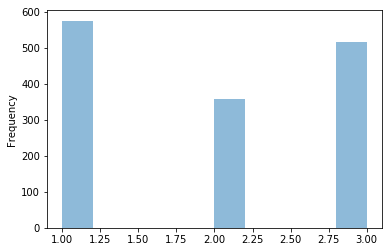

In [2]:
MAX_SEQUENCE_LENGTH = 1000 # top 30
MAX_NB_WORDS = 20000 # more than vocab size
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


data_train = pd.read_csv('../result_all_windows_labels.csv')

# Cleanup - remove no labels
data_train = data_train[data_train['label'].notnull()]
data_train = data_train[data_train.label != 'environmental']
data_train = data_train[data_train.label != 'religious']
data_train = data_train[data_train.label != 'economical']


label_cat = {'violence/terrorism' : 1, 'misc': 2, 'political': 3, 
#              'religious': 4, 'economical': 5, 'environmental': 6
            }
print(label_cat) 


def to_category(x):
    return label_cat[x]

data_train['target'] = data_train.apply(lambda row: to_category(row['label']), axis=1)

data_train['target'].plot.hist(alpha=0.5)

texts = []
# Get corpus by joining all keywords
for index, row in data_train.iloc[ :, 2:32].iterrows():
    texts.append(u' '.join(row.tolist()))
    
data_train['topicFlat'] = texts

labels = data_train['target']

# print(labels)
data_train['topicFlat'].head()

Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [10]:
# data = data[data.sentiment != "Neutral"]
# data['text'] = data['text'].apply(lambda x: x.lower())
# data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

# print(data[ data['sentiment'] == 'Positive'].size)
# print(data[ data['sentiment'] == 'Negative'].size)

# for idx,row in data.iterrows():
#     row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data_train['topicFlat'].values)
X = tokenizer.texts_to_sequences(data_train['topicFlat'].values)
print(X[0])
X = pad_sequences(X)
print(X[0])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) # all the tokens in corpus

print(X.shape)

[4, 17, 1, 2, 16, 42, 7, 47, 178, 56, 30, 1014, 395, 8, 160, 22, 38, 12, 201, 142, 10, 3, 17, 1640, 202, 433, 396, 307, 82, 145, 649]
[   0    0    0    0    0    0    4   17    1    2   16   42    7   47  178
   56   30 1014  395    8  160   22   38   12  201  142   10    3   17 1640
  202  433  396  307   82  145  649]
Found 6077 unique tokens.
(1449, 37)


Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [11]:
# Y = data_train['target'].values

Y = pd.get_dummies(data_train['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(Y_train[100])
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[0 0 1]
(1159, 37) (1159, 3)
(290, 37) (290, 3)


In [12]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 37, 128)           256000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None
Train on 1159 samples, validate on 290 samples
Epoch 1/100
1159/1159 [==============================] - 18s 16ms/step - loss: 1.0961 - acc: 0.3814 - val_loss: 1.0911 - val_acc: 0.4586
Epoch 2/100
1159/1159 [==============================] - 20s 17ms/step - loss: 1.0819 - acc: 0.4487 - val_loss: 1.0652 - val_acc: 0.4103
Epoch 3/100
1159/1159 [==============================] - 19s 17ms/step - l

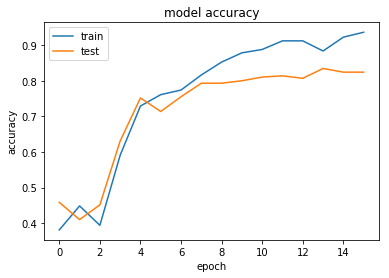

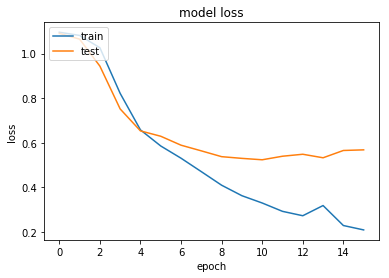

In [19]:
embed_dim = 128
lstm_out = 196
epochs = 100

sequence_length = X.shape[1] # 

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length=sequence_length))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_cat), activation='softmax'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss = 'categorical_crossentropy',
              optimizer=adam, metrics = ['accuracy'])
print(model.summary())


batch_size = 32

model_name = 'topicConvNet-Reg.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# checkpoint = ModelCheckpoint(model_name, verbose=0, save_best_only=True)

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', verbose=0, save_best_only=True, mode='max')

network_hist = model.fit(X_train, Y_train, epochs = epochs, 
                         validation_data=(X_test, Y_test), 
                         callbacks=[early_stop, checkpoint],
                         validation_split=0.2,
                         verbose=1, batch_size=batch_size)

score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

# print(network_hist.history)
plot_history(network_hist)

# CNN-text-classification

37
1449
Creating Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 37)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 37, 256)      1555712     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 37, 256, 1)   0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 35, 1, 128)   98432       reshape_1[0][0]                  
___________________________________________________________________________________

1159/1159 [==============================] - 36s 31ms/step - loss: 0.0741 - acc: 0.9974 - val_loss: 0.4258 - val_acc: 0.8517
Epoch 00036: early stopping
290/290 [==============================] - 1s 2ms/step
Test score: 0.425814135321
Test accuracy: 0.851724137931
dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


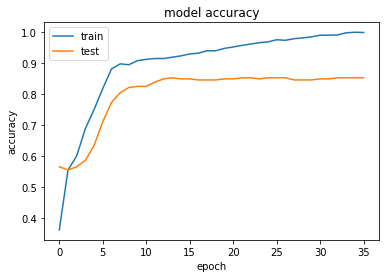

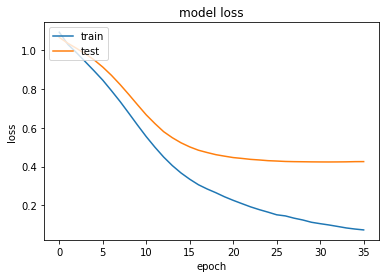

CPU times: user 37min 34s, sys: 1h 55min 53s, total: 2h 33min 27s
Wall time: 20min 21s


In [15]:
%%time 

# Source
# https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py

sequence_length = X.shape[1] # 
print(sequence_length)
print(len(X))

vocabulary_size = len(word_index) # 
embedding_dim = 256
filter_sizes = [3,4,5]
num_filters = 128 # 512
drop = 0.2

epochs = 100
batch_size = 30

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, 
                      input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=len(label_cat), activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
print(model.summary())


early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', verbose=0, 
                             save_best_only=True, mode='auto')

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', 
              metrics=['accuracy'])
print("Traning Model...")
network_hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                         epochs=epochs, verbose=1, 
                         callbacks=[early_stop, checkpoint], 
                         validation_data=(X_test, Y_test))  # starts training

score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

# print(network_hist.history)
plot_history(network_hist)